In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
from collections import defaultdict
from itertools import chain
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
sponge_df = pd.read_csv('sponge_df_script.csv',index_col= 0, converters={'Script': literal_eval})

Create list of dictionaries for character word counts each episode

In [2]:
# create character word_counts
list_of_character_word_counts = []
for title in list(sponge_df.Title):
    character_dict = defaultdict(int)
    episode_name = title
    script = list(sponge_df.query("Title == @episode_name")['Script'])[0]
    for i in range(len(script)):
        try:
            character_dict[script[i].split(':')[0]] += \
                len(script[i].split(':')[1].split())
        except:
            pass
    character_dict = sorted(
        character_dict.items(),
        key=lambda x: x[1],
        reverse=True)
    list_of_character_word_counts.append(dict(character_dict))

In [3]:
char_counts = Counter(list(chain(*[
    list(list_of_character_word_counts[i].keys()) 
    for i in range(len(list_of_character_word_counts))
    ])))

We just want the characters that appear relatively frequently, so we're gonna set the bar to 30.

In [4]:
app_dict = {x: count for x, count in char_counts.items() if count >= 30}

Now, let's create a helper function so we can apply to dataframe

In [6]:
# create a copy of the dataframe, we don't wanna mess with the original 
sponge_df_app_share  = sponge_df.copy()


Make a column that has a list of all characters that appear in said episode

In [7]:
list(set([x.split(':')[0] for x in sponge_df.Script[0]]))
sponge_df_app_share['allchars'] = \
sponge_df_app_share.Script.apply(lambda y: 
                                 list(
    set([x.split(':')[0] for x in y])))

Helper function to create character columns

In [8]:
def isinlist(list,char):
    if char in list:
        return 1 
    else:
        return 0

Iterate through each character and make the columns binary: 
1. 1 if speaking role in episode
1. 0 if no speaking role in episode 

Creating character columns ... 

In [9]:
for character in list(app_dict.keys()):
    sponge_df_app_share[character] = \
    sponge_df_app_share['allchars'].apply(
        isinlist, char = character)

Now, let's find p-values to see if there's a difference in episodes with vs without them. That's why we set a min sample size so that the min reasonable value of appearances is 30.

In [10]:
pvalues = [stats.ttest_ind(sponge_df_app_share['Rating'][sponge_df_app_share[character] == 1],
                sponge_df_app_share['Rating'][sponge_df_app_share[character] == 0])[1]
                for character in list(app_dict.keys())]

Means with and without said character

In [11]:
with_ = [sponge_df_app_share[sponge_df_app_share[character] == 1
                             ].Rating.mean().__round__(2) \
    for character in list(app_dict.keys())]

without_ = [sponge_df_app_share[sponge_df_app_share[character] == 0
                             ].Rating.mean().__round__(2) \
    for character in list(app_dict.keys())]

Turn it all into a dataframe and sort by pvalues

In [15]:
chars_df = pd.DataFrame({
    'characters':list(app_dict.keys()),
    'p-values':pvalues,
    'with_character': with_,
    'without_character': without_}).sort_values(by = 'p-values',
            ascending = True)
chars_df#.style.set_caption('Differences in IMDB Ratings based on if a character appears (with means)')

,characters,p-values,with_character,without_character
9,Narrator,0.005432,7.56,7.17
18,Nat,0.015233,6.85,7.31
7,All,0.042935,7.65,7.22
13,SpongeBob and Patrick,0.078305,7.45,7.20
15,Fred,0.141144,7.46,7.22
0,SpongeBob,0.169578,7.25,8.20
10,Harold,0.245835,7.11,7.29
14,Mrs. Puff,0.362553,7.11,7.28
4,French Narrator,0.371422,7.41,7.24
1,Mr. Krabs,0.379910,7.22,7.33


Interesting how significant the Narrator is ... and that the "French Narrator" is not. Let's investigate this further with a combined p-value

In [101]:
stats.ttest_ind(sponge_df_app_share['Rating'][sponge_df_app_share['Narrator'] \
    + sponge_df_app_share['French Narrator'] >= 1],
                sponge_df_app_share['Rating'][sponge_df_app_share['Narrator'] \
    + sponge_df_app_share['French Narrator'] != 1])[1]

0.00235404840947637

Regardless of which narrator, the appearance is still significant!

In [99]:
sponge_df_app_share[
    sponge_df_app_share['Narrator'] \
    + sponge_df_app_share['French Narrator'] == 1]

,Episode #,Title,Rating,Script,allchars,SpongeBob,Mr. Krabs,Squidward,Patrick,French Narrator,...,Narrator,Harold,Plankton,Karen,SpongeBob and Patrick,Mrs. Puff,Fred,Pearl,Both,Nat
0,0,Help Wanted,8.7,"[French Narrator: Ah, the sea... so fascinatin...","[SpongeBob, Squidward, SpongeBob SquarePants, ...",1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,4,Ripped Pants,8.5,"[Narrator: Ah, Goo. Lagoon. A stinky mud puddl...","[SpongeBob, Jennifer, Scooter, All, Lou, Pants...",1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
13,13,Hall Monitor,8.5,[Narrator: Mrs. Puff's Boating School. Where d...,"[SpongeBob, Officer John, Tina, Phil, Jimmy, S...",1,0,0,1,0,...,1,0,0,0,0,1,1,0,0,0
20,20,F.U.N.,8.7,"[Narrator: Ahh, lunchtime at the Krusty Krab. ...","[SpongeBob, Squidward, All, Movie Woman, Squid...",1,1,1,0,0,...,1,0,1,1,0,0,0,0,0,0
25,25,SB-129,9.1,"[Voice: SB-129. , Narrator: Ahh, it is Sunday ...","[SpongeBob, Squidward, Time Machine, SpongeBob...",1,0,1,1,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,468,The Krusty Slammer,6.5,"[Plankton: Huh?, Lady officer: Hey, you! You...","[SpongeBob, Squidward, Prisoner #3, Dorsal Dan...",1,1,1,0,1,...,0,0,1,0,0,0,1,0,0,0
470,470,Gary's Got Legs,7.2,"[SpongeBob: Okay, that's enough stretching., G...","[SpongeBob, Sheldon, Squidward, Bikini Bottomi...",1,1,1,0,1,...,0,0,0,0,0,0,1,0,0,0
476,476,Broken Alarm,7.6,[Mr. Krabs: Mr. Squidward! What is happening ...,"[SpongeBob, Squidward, Bubble Bass, Bikini Bot...",1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
480,480,SpongeBob's Big Birthday Blowout,8.7,"[Original Version, Patchy: Oh, hi, kids! Patch...","[Potty, John Goodman, Vernon Davis, Mr. Krabs,...",1,1,1,1,1,...,0,0,1,0,1,1,1,0,0,0


Text(0.5, 1.0, 'French Narrator appearances in 43 episodes')

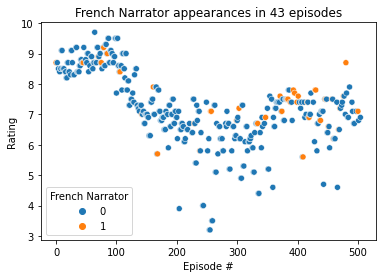

In [25]:
sns.scatterplot(data = sponge_df_app_share,
             x  = 'Episode #',
             y = 'Rating',
             hue = 'French Narrator')
plt.title('French Narrator appearances in {} episodes'
          .format(sum(sponge_df_app_share['French Narrator'])))

Now we know that characters' appearances can have a significant effect in the rating, can we possibly analyze how much they talk has an effect too? If we iterate through `list_of_character_word_counts` for our select characters, maybe we can see if we can spot some sort of correlation! 

In [28]:
# let's mess with the helper function we used to create the code, but the structure of the code should be fine

In [77]:
full_char_list = []
for character in list(app_dict.keys()):
    char_list = []
    for dict in list_of_character_word_counts:
        if dict.get(character):
            char_list.append(dict.get(character))
        else:
            char_list.append(0)
    full_char_list.append(char_list)


In [79]:

# copy existing dataframe 
sponge_df_char_wc = sponge_df.copy()

# iterate through relevant characters 
for i in range(len(list(app_dict.keys()))):
    character = list(app_dict.keys())[i]
    sponge_df_char_wc[character] = \
    full_char_list[i]

Previewing what this gets us...

In [81]:
sponge_df_char_wc.head(5)

,Episode #,Title,Rating,Script,SpongeBob,Mr. Krabs,Squidward,Patrick,French Narrator,Gary,...,Narrator,Harold,Plankton,Karen,SpongeBob and Patrick,Mrs. Puff,Fred,Pearl,Both,Nat
0,0,Help Wanted,8.7,"[French Narrator: Ah, the sea... so fascinatin...",112,85,73,66,15,1,...,0,0,0,0,0,0,0,0,0,0
2,2,Tea at the Treedome,8.7,"[Sandy Cheeks: Take that, you sorry old clam! ...",145,0,0,82,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,Ripped Pants,8.5,"[Narrator: Ah, Goo. Lagoon. A stinky mud puddl...",193,0,0,0,0,0,...,23,6,0,0,0,0,0,0,0,0
6,6,Plankton!,8.4,"[Squidward: Come on, SpongeBob!, SpongeBob: Ne...",207,55,39,0,0,0,...,0,0,227,1,0,0,0,0,0,0
7,7,Naughty Nautical Neighbors,8.5,"[Squidward: Wow. Squidward, this is the best s...",234,0,168,127,0,0,...,0,0,0,0,7,0,0,0,0,0


In [95]:
# for character in list(app_dict.keys()):
pd.DataFrame({
    'character':list(app_dict.keys()),
    'correlation with rating':[sponge_df_char_wc[sponge_df_char_wc[character] > 1]
[[character,'Rating']].corr().iloc[0,1] for character in list(app_dict.keys())]})

,character,correlation with rating
0,SpongeBob,0.103378
1,Mr. Krabs,0.008455
2,Squidward,0.120897
3,Patrick,0.004776
4,French Narrator,0.121872
5,Gary,-0.003078
6,Sandy,0.044919
7,All,0.112585
8,Larry,-0.079913
9,Narrator,0.236380


To use the list of relevant characters in other files, let's pickle this...

In [97]:
pd.to_pickle(list(app_dict.keys()),'relevant_chars')